In [82]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
#Đọc file
import pandas as pd
path_csv = 'VIC.csv'
#mount google driver  ('/content/drive/MyDrive/Project/VIC.csv')
data_read = pd.read_csv(path_csv)
data_read.index = pd.to_datetime(data_read['Date/Time'])
min = data_read['Close'].min()
max = data_read['Close'].max()
min2 = data_read['Volume'].min()
max2 = data_read['Volume'].max()
print(min, max)
print(min2, max2)
print(len(data_read))

68.0 126.5
10 1468390
101266


In [ ]:
!pip install --upgrade tensorflow

In [83]:
import tensorflow as tf
import keras
from keras.layers import LSTM
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.13.0


In [84]:
#Config
time_step = 20
future_time = 1
rate_split = 0.8
rate = 60

hidden_dim = 50
dropout_rate = 0.5
loss_fn = 'mean_squared_error'
batch_size = 64
epoch = 1000
opt = 'adam'
lstm = LSTM

In [85]:
#Up date index theo phút, thây thế giá trị NaN bằng 0
start=data_read['Date/Time'][0]
time_str_start= start[0:len(start)-5] + ' 9:00'
end=data_read['Date/Time'][len(data_read['Date/Time'])-1]
time_str_end = end[0:len(start)-5] + ' 14:59'
new_update = pd.date_range(start=time_str_start, end= time_str_end, freq='min')
data_read = data_read.reindex(new_update)
data_read = data_read.rename_axis('Date')
data_read_new = data_read.drop(['Ticker', 'Date/Time', 'Open', 'High', 'Low', 'Open Interest'], axis=1)
data_read_new_update = data_read_new.fillna(0)
#dataframe gồm 2 cột là Close và Volume
print(time_str_end)
print(time_str_start)
# print(new_update)

12/22/2020 14:59
10/17/2018 9:00


In [86]:
#Biến đổi DataFrame chuỗi thời gian là 1 phút sang các chuỗi thời gian khác rate={30p, 1 giờ, ...}
def MinToOtherTime(in_data,rate):
    data = in_data.copy()
    count = 0
    num_of_value_0 = 0
    value_close = 0
    value_volume = 0
    Close =[]
    Volume = []
    for i in range(len(data)):


        if data['Close'][i] == 0:
            num_of_value_0  = num_of_value_0 + 1
        value_close += data['Close'][i]
        value_volume += data['Volume'][i]
        count +=1
        if count == rate and num_of_value_0 == rate:
            mean_value_close = 0
            value_volume = 0
            Close.append(mean_value_close)
            Volume.append(value_volume)
            count = 0
            num_of_value_0 = 0

        elif count == (rate) and count != num_of_value_0:
            mean_value_close = value_close/(count - num_of_value_0)
            num_of_value_0 = 0
            Close.append(mean_value_close)
            Volume.append(value_volume)
            value_close = 0
            value_volume = 0
            count = 0
    df = pd.DataFrame({'Close':Close, 'Volume':Volume})
    return df

In [87]:
data_trasform = MinToOtherTime(data_read_new_update, rate)
print(len(data_trasform))
print(data_trasform.head(30))

19134
        Close    Volume
0   98.668421  121310.0
1   98.848000  261510.0
2   98.553846  180140.0
3    0.000000       0.0
4   98.547826  236090.0
5   98.507407  467560.0
6    0.000000       0.0
7    0.000000       0.0
8    0.000000       0.0
9    0.000000       0.0
10   0.000000       0.0
11   0.000000       0.0
12   0.000000       0.0
13   0.000000       0.0
14   0.000000       0.0
15   0.000000       0.0
16   0.000000       0.0
17   0.000000       0.0
18   0.000000       0.0
19   0.000000       0.0
20   0.000000       0.0
21   0.000000       0.0
22   0.000000       0.0
23   0.000000       0.0
24  98.260000   54170.0
25  98.820000  110150.0
26  98.658824   38120.0
27   0.000000       0.0
28  98.692453  434150.0
29  98.951613  259550.0


In [88]:
#Loại bỏ tất cả các hàng có giá trị 0
data_use_train = data_trasform[~(data_trasform == 0).all(axis=1)]
print(data_use_train.head(10))
print(data_use_train.shape)

        Close    Volume
0   98.668421  121310.0
1   98.848000  261510.0
2   98.553846  180140.0
4   98.547826  236090.0
5   98.507407  467560.0
24  98.260000   54170.0
25  98.820000  110150.0
26  98.658824   38120.0
28  98.692453  434150.0
29  98.951613  259550.0
(2740, 2)


In [41]:
print(data_use_train['Close'].min())
print(data_use_train['Close'].max())
print(data_use_train['Volume'].min())
print(data_use_train['Volume'].max())

70.98
126.1
50.0
1468390.0


In [89]:
#Chuẩn hóa dữ liệu dùng min max scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
values = scaler.fit_transform(data_use_train.values)
df_values = pd.DataFrame(values, columns =['Close', 'Volume'])
print(df_values.head(10))

      Close    Volume
0  0.500621  0.070711
1  0.503920  0.153443
2  0.498516  0.105427
3  0.498406  0.138442
4  0.497663  0.275032
5  0.493119  0.031092
6  0.503406  0.064126
7  0.500445  0.021621
8  0.501063  0.255317
9  0.505823  0.152286


In [90]:
#Hàm tạo dataframe mới ({'close' 'close +1' ... 'close +i'} {'Volume', 'VOlume +1',...,'Volume +i} {target})
def create_data_train(df_values, time_step, future_time):
    in_data = df_values.copy()
    cols_list_new = []
    colunms = ['Close', 'Volume']
    cols_list_new = []
    for colunm in colunms:
        i = 1
        while i < time_step:
            in_data[colunm + " +{}".format(i)] = in_data[colunm].shift(-i)
            i = i + 1
    in_data["target"] = in_data["Close"].shift(-time_step - future_time + 1)
    result = in_data.dropna(axis=0)
    cols_list = result.columns.tolist()
    cols_list_new = cols_list[0:1] + cols_list[2:time_step+1] + cols_list[1:2] +  cols_list[time_step+1:-1] + cols_list[-1:]
    out_data = result[cols_list_new]
    return out_data

In [ ]:
df_train = create_data_train(df_values, time_step,future_time)
print(len(df_train))
print(df_train.head(10))
print(data_use_train.head(10))

In [92]:
#hàm chia dữ liệu train và dữ liệu test
def train_test_split(rate_split, data):
    num_train = int(rate_split*len(data))
    train_data = data[:num_train, :]
    test_data = data[num_train: , :]

    x_train, y_train = train_data[:, :-1], train_data[:, -1]
    x_test, y_test = test_data[:, :-1], test_data[:, -1]
    return x_train, x_test, y_train, y_test

In [93]:
x_train, x_test, y_train, y_test = train_test_split(rate_split, df_train.values)
print(len(x_train))
print(len(x_test))
#thay đổi chiều dữ liệu của tập x
x_train = x_train.reshape((x_train.shape[0],time_step,-1))
x_test = x_test.reshape((x_test.shape[0], time_step, -1))
print('Train on {} sample. test on {} sample'.format(x_train.shape[0], x_test.shape[0]))

2176
544
Train on 2176 sample. test on 544 sample


In [ ]:
print(x_train.shape)

(2457, 10, 2)


In [94]:
#Tạo model
x = Input(name='input', shape=(time_step, 2), dtype='float32')
lstm_1 = lstm(hidden_dim, input_shape=(time_step, 2),
              return_sequences=True, name='lstm_1')(x)
dropout_1 = Dropout(dropout_rate, name = 'dropout_1')(lstm_1)
lstm_2 = lstm(50, input_shape=(time_step, 2),
              return_sequences=False, name='lstm_2')(dropout_1)
dropout_2 = Dropout(dropout_rate, name = 'dropout_2')(lstm_2)
dense_1 = Dense(50, activation='relu', name='dense_1')(dropout_2)
y = Dense(1, activation='linear', name='dense_2')(dense_1)
model = Model(inputs=x, outputs=y, name = 'Model')
model.compile(loss=loss_fn, optimizer=opt)



In [ ]:
model.summary()

In [97]:
#checkpoint
from keras.callbacks import ModelCheckpoint
checkpoint_path = '/content/drive/MyDrive/Project/weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_best_only=True,
                             save_weights_only=True,
                             monitor='val_loss', mode='min', verbose=1)
callbacks_list = [checkpoint]

In [ ]:
#train model
history = model.fit(x_train, y_train, callbacks=callbacks_list,
                    epochs= epoch, batch_size=batch_size,
                    validation_data=(x_test, y_test), shuffle=False)

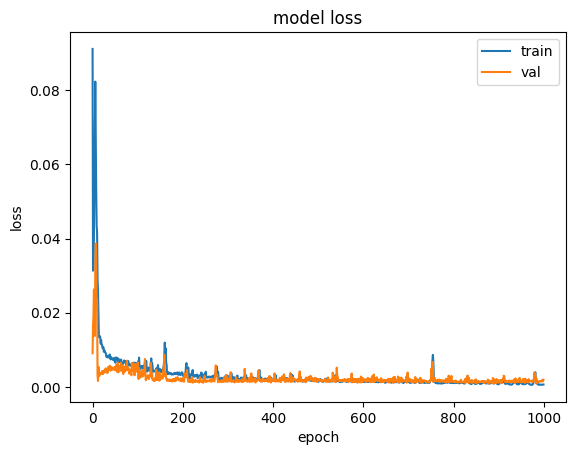

In [99]:
#vẽ bảng so sánh loss_train và loss_validition
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [102]:
#tạo model test load lại trọng số từ checkpoint
x = Input(name='input', shape=(time_step, 2), dtype='float32')
lstm_1_test = lstm(hidden_dim, input_shape=(time_step, 2),
              return_sequences=True, name='lstm_1_test')(x)
dropout_1_test = Dropout(dropout_rate, name = 'dropout_1_test')(lstm_1_test)
lstm_2_test = lstm(50, input_shape=(time_step, 2),
              return_sequences=False, name='lstm_2_test')(dropout_1_test)
dropout_2_test = Dropout(dropout_rate, name = 'dropout_2_test')(lstm_2_test)
dense_1_test = Dense(50, activation='relu', name='dense_1_test')(dropout_2_test)
y = Dense(1, activation='linear', name='dense_2')(dense_1_test)
model_test = Model(inputs=x, outputs=y, name = 'Model_test')
model_test.load_weights('weights.best.hdf5')
#mount driver (/content/drive/MyDrive/Project/weights.best.hdf5)
model_test.compile(loss=loss_fn, optimizer=opt)


model_test.summary()


Model: "Model_test"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 20, 2)]           0         
                                                                 
 lstm_1_test (LSTM)          (None, 20, 50)            10600     
                                                                 
 dropout_1_test (Dropout)    (None, 20, 50)            0         
                                                                 
 lstm_2_test (LSTM)          (None, 50)                20200     
                                                                 
 dropout_2_test (Dropout)    (None, 50)                0         
                                                                 
 dense_1_test (Dense)        (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 1)                 5

In [103]:
#đánh giá
from sklearn.metrics import mean_squared_error
y_pred = model_test.predict(x_test)
p_x_test = x_test[:,0,:].reshape((x_test.shape[0],2))
inv_y_pred = np.concatenate((y_pred,p_x_test[:,-1].reshape((len(p_x_test), 1))), axis=1)
inv_y_pred = scaler.inverse_transform(inv_y_pred)
inv_y_pred = inv_y_pred[:,0]

y_test_=y_test.reshape((len(y_test), 1))
inv_y_test = np.concatenate(( y_test_,p_x_test[:,-1].reshape((len(p_x_test), 1))), axis=1)
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_test = inv_y_test[:, 0]

rmse = np.sqrt(mean_squared_error(inv_y_test, inv_y_pred))
print('Test RMSE: %.3f' % rmse)

17/17 [==============================] - 2s 22ms/step
Test RMSE: 1.654


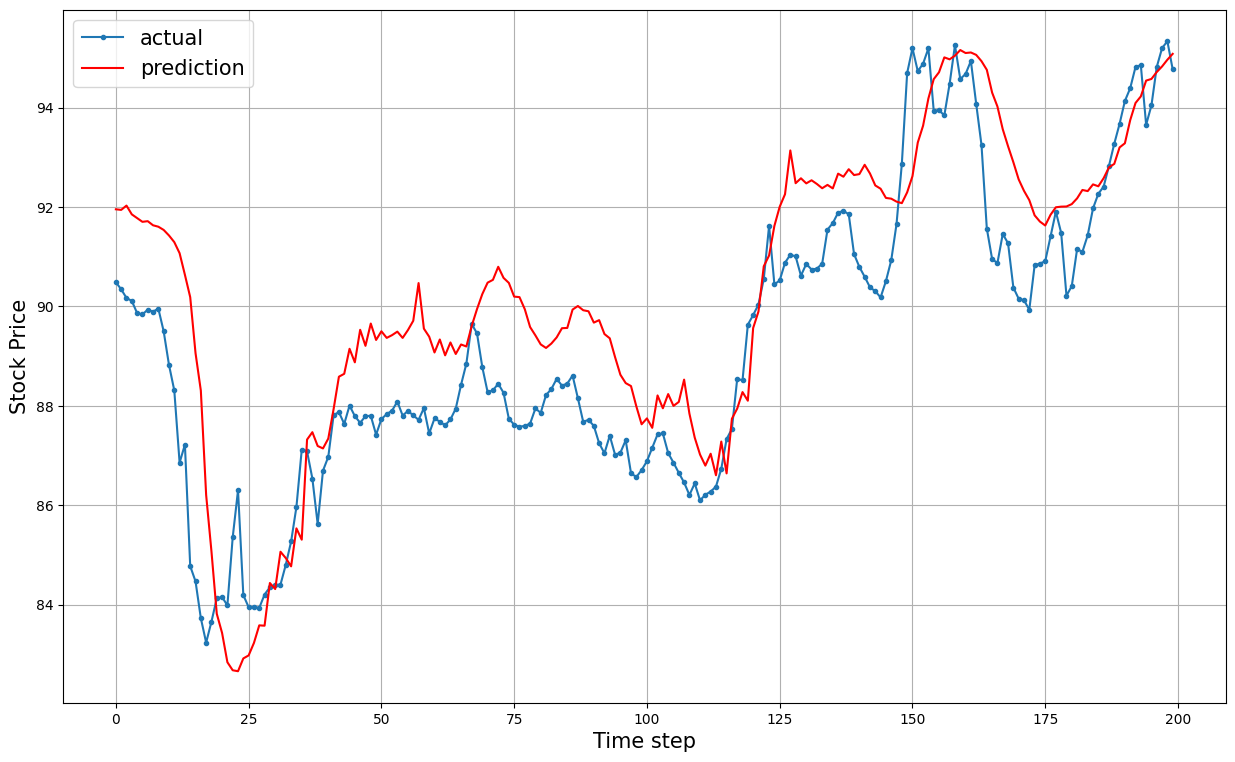

In [104]:
#vẽ bảo so sánh giá trị dự đoán và giá trị thực tế
plt.figure(figsize=(15,9))
aa=[x for x in range(200)]
plt.plot(aa, inv_y_test[:200], marker='.', label="actual")
plt.plot(aa, inv_y_pred[:200], 'r', label="prediction")
plt.ylabel('Stock Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.grid()
plt.show()

- Dữ liệu đưa vào model_train là file csv chứa chuỗi giá của cổ phiếu theo đơn vị là phút

-Dữ liệu đưa vào predict_fluctuations là file csv chứa chuỗi giá trị của cổ phiếu theo đơn vị là phút. Số lượng tùy vào mốc thời gian muốn dự đoán. số lượng sẽ bằng rate*time_step
